# Predspracovanie údajov

- Na začiatok si naimportujeme niektoré dôležité knižnice, s ktorými budeme v tejto správe pracovať.

In [1]:
import pandas as pd
import scipy
import math
import matplotlib.pyplot as plt
import random as rn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, PowerTransformer
from matplotlib import pyplot

- Teraz otvoríme všetky 3 súbory a uložíme ich ako dataframe.

In [2]:
PRODUCT_FILE_PATH = "resources/product.csv"
USER_FILE_PATH = "resources/user.csv"
SESSION_FILE_PATH = "resources/session.csv"

prod_df = pd.read_csv(PRODUCT_FILE_PATH, delimiter='\t')
user_df = pd.read_csv(USER_FILE_PATH, delimiter='\t')
sess_df = pd.read_csv(SESSION_FILE_PATH, delimiter='\t')

## Integrácia a čistenie dát

### Spracovanie chýbajúcich údajov
- V tejto časti sa venujeme nešpecifikovaným hodnotám (NaN). Na spracovanie všetkých 3 datasetov používame funkciu *process_missing_vals(df, limit)*. Táto funkcia spracúva daný dataframe po jednotlivých stĺpcoch. Ak je v danom stĺpci počet hodnôt NaN pod limitom (teda je akceptovateľný), tak sú dané riadky odstránené. Na určenie miery akceptovateľnosti sa používa atribút *limit*, ktorý predstavuje percento akceptovateľnosti. V prípade, že hodnoty sú nad limitom, tak sú nahradené:

    1. __modusom__ (najčastejšia hodnota) v prípade __nenumerických__ dát
    2. __mediánom__ v prípade __numerických__ dát

- Je nutné pripomenúť, že funkcia priamo mení dané datasety, takže pri opätovných pokusoch o spustenie bunky nižšie budú výsledky také, že všetky stĺpce neobsahujú žiadne NaN.

In [3]:
def process_missing_vals(dataframe, limit=1):
    print(f'\nstarting the process...')

    #Here we calculate the actual limit for NaNs which can be dropped
    limit_count = math.ceil((len(dataframe) / 100) * limit)
    print(f'Limit: {limit_count}')
    
    for col in dataframe.columns:
        na_count_before = dataframe[col].isna().sum()

        #If there are no NaNs in the current column, we move to the next one
        if na_count_before == 0:
            print(f"Column '{col}': No NaN values initially.")
            continue

        #If the count of NaNs is acceptable, we remove the rows containing them
        if na_count_before <= limit_count:
            print(f"Column '{col}': Dropping NaN values...")
            dataframe.dropna(subset=[col], inplace=True)
        #else we apply different strategies for numeric and non-numeric data
        else:
            print(f"Column '{col}': Too many NaN values...", end=" ")
            is_numeric = pd.to_numeric(dataframe[col], errors='coerce').notna().all()
            
            if not is_numeric:
                print("Imputing the most common value...")
                most_common_value = dataframe[col].mode()[0]  # Get the most common value
                dataframe[col].fillna(most_common_value, inplace=True)
            else:
                print("Imputing the median value...)")
                median = dataframe[col].median()
                dataframe[col].fillna(median, inplace=True)    
        
        na_count_after = dataframe[col].isna().sum()
        print(f"NaN count before - {na_count_before}, after - {na_count_after}")

    print(f'Process done!\n')

#Processing product dataframe
print("Original Length:", len(prod_df))
process_missing_vals(prod_df)
print("New Length:", len(prod_df))

#Processing user dataframe
print("Original Length:", len(user_df))
process_missing_vals(user_df)
print("New Length:", len(user_df))

#Processing session dataframe
print("Original Length:", len(sess_df))
process_missing_vals(sess_df)
print("New Length:", len(sess_df))

Original Length: 14967

starting the process...
Limit: 150
Column 'location': No NaN values initially.
Column 'product_ean': No NaN values initially.
Column 'store_name': No NaN values initially.
Column 'code': Dropping NaN values...
NaN count before - 22, after - 0
Process done!

New Length: 14945
Original Length: 2533

starting the process...
Limit: 26
Column 'address': Too many NaN values... Imputing the most common value...
NaN count before - 380, after - 0
Column 'name': No NaN values initially.
Column 'race': Too many NaN values... Imputing the most common value...
NaN count before - 1773, after - 0
Column 'registration': No NaN values initially.
Column 'username': No NaN values initially.
Column 'current_location': Too many NaN values... Imputing the most common value...
NaN count before - 127, after - 0
Column 'sex': Too many NaN values... Imputing the most common value...
NaN count before - 1266, after - 0
Column 'birthdate': Too many NaN values... Imputing the most common val

- Teraz sa môžme ísť pozrieť na výsledky spracovávania. Vidno, že súbor s produktami mal najmenej nešpecifikovaných hodnôt, a to len 22 v prípade atribútu code. Keďže ide o zanedbateľné množstvo, tak boli tieto hodnoty odstránené. V prípade __datasetu s používateľmi__, tak tam bolo naopak najviac nešpecifikovaných hodnôt. Vždy bol prekročený aj limit akceptovateľnosti, takže žiadny riadok nebol v tomto prípade odstránený, ale nahradený najčastejšou hodnotou, nakoľko išlo o nenumerické dáta. V prípade posledného súboru išlo vždy o zanedbateľné množstvá NaN hodnôt, takže všetky boli odstránené.
- Nižšie sme si zadefinovali funkcie na zobrazovenie distribúcií rozdelení na grafoch. Nižšie vypisujeme niektoré zaujímavé prípady.

In [4]:
def plt_dis(df, name = 'unknown', bar_limit = 25):
    counts = df.value_counts().head(bar_limit)

    colors = ['Red', 'Blue', 'Green', 'Black', 'Yellow', 'Orange', 'Purple', 'Pink']
    rn.shuffle(colors)
    
    counts.plot(kind='bar', color=colors, alpha=1)
    plt.ylim(0, max(counts) + 10*(max(counts)/100))
    plt.xlabel(f'{name}')
    plt.ylabel('Count')
    plt.title(f"'{name}' distribution")
    plt.show()

def plt_table_dis(df, bar_limit = 25):
    
    for col in df:
        plot_distribution(df[col], col)

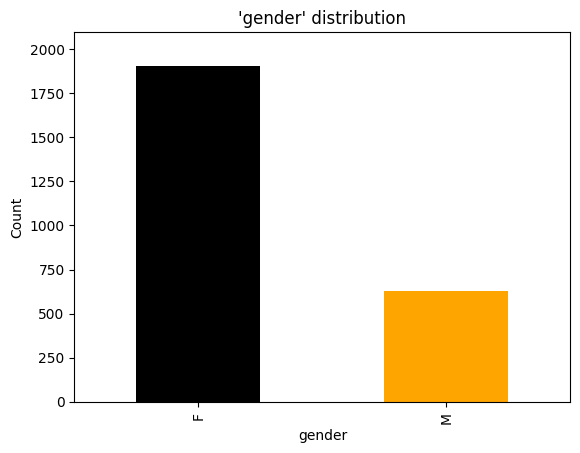

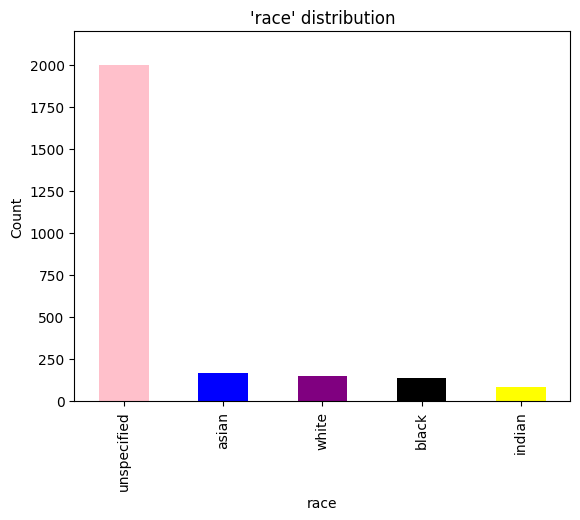

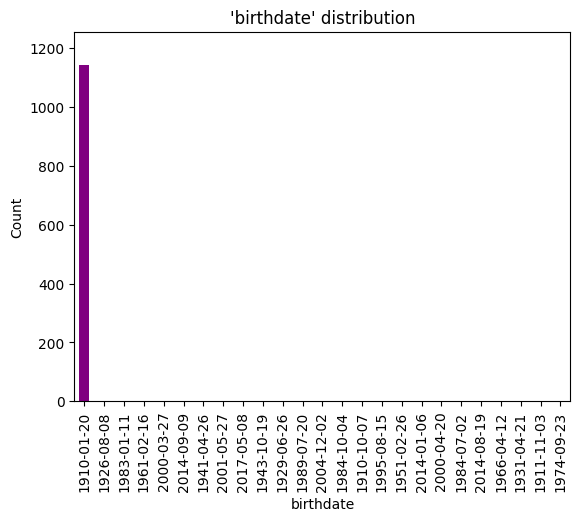

In [5]:
plt_dis(user_df['sex'], 'gender')
plt_dis(user_df['race'], 'race')
plt_dis(user_df['birthdate'], 'birthdate')

- Dané distribúcie pochádzajú z datasetu užívateľov, ktorý súčasne obsahuje najväčší výskyt nešpecifikovaných hodnôt. V prvom grafe vidíme, že v prípade pohlaví je teraz oveľa viac zastúpené ženské pohlavie, pretože to bolo v pôvodnom datasete najčastejšie sa vyskytujúca hodnota. V druhom prípade sa to isté uplatnilo na atribút 'unspecified', čo je ale tentokrát lepšie, pretože žiadna hodnota nie je nadmerne preferovaná. Najhorší prípade je posledný, kedy obrovkské množstvo nešpecifikovaných hodnôt preferuje hodnotu modus. Stále sme ale aspoň neprišli o veľké množstvo dát, ak by sme tieto hodnoty vypustili z datasetu.

### Spracovanie vychýlených hodnôt
- V tejto časti spracovávame významne vychýlené dáta, tzv. __outliers__, tak, že ich buď:

  1) __odstránime__, ak ide o zadedbateľné množstvo, inak
  2) __nahradíme hraničnou hodnotou__

- Najskôr si pre otestovanie, či náš systém spracovávania takýchto hodnôt funguje správne, vytvoríme niekoľko pomocných funkcií definovaných nižšie. Najdôležitejšia je v tomto prípade funkcia _top_outlier_data(df, limit)_, ktorá identifikuje stĺpce s najväčším počtom outlier-ov na základe atribútu _limit_. Následne vypíše ich distribúcie pomocou BoxPlot-ov, v ktorých sú zobrazené dané outlier-y.

Column 'browser_name': Not numerical! Skipping...
Column 'session_start': Not numerical! Skipping...
Column 'screen_width': Not numerical! Skipping...
Column 'screen_height': Not numerical! Skipping...


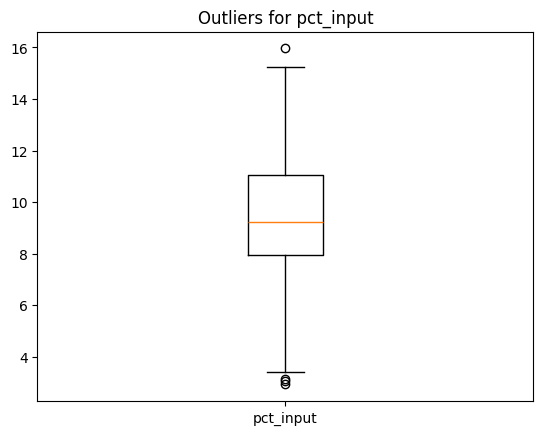

Outliers: 179


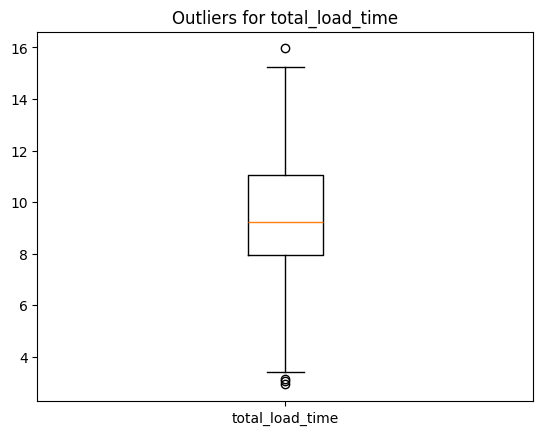

Outliers: 171


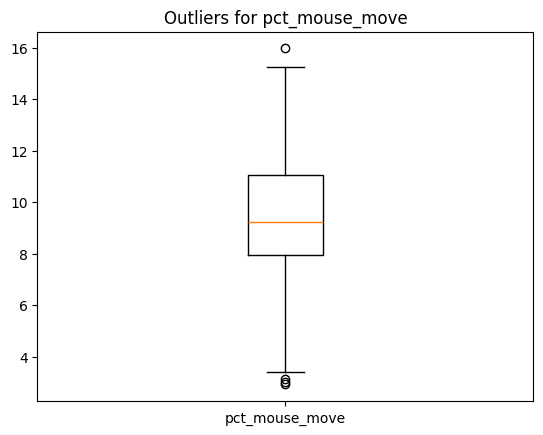

Outliers: 89


In [6]:
def plt_outliers(df, name='unknown'):    
    if not pd.to_numeric(df, errors='coerce').notna().all():
        print("Detected non-numerical data!")
        return
    
    plt.boxplot(sess_df['wild_mouse_duration'], labels=[name])
    plt.title(f"Outliers for {name}")
    plt.show()

def plt_table_outliers(df):
    for col in df:
        plt_outliers(df[col], col)

def top_outlier_data(df, threshold = 3, limit = 3):
    max = []
    
    for col in df:
        if not pd.to_numeric(df[col], errors='coerce').notna().all():
            print(f"Column '{col}': Not numerical! Skipping...")
            continue

        z_scores = (df[col] - df[col].mean()) / df[col].std()
        outliers = len(df[col][abs(z_scores) > threshold])
        
        if outliers > 0:
            if len(max) == 0 or len(max) < limit:
                max.append({'col': col, 'outliers': outliers})
                continue

            remove = -1
            rate = -1
            for i in range(0, limit):
                if max[i]['outliers'] < outliers and (rate == -1 or outliers - max[i]['outliers'] > rate):
                    remove = i
                    rate = outliers - max[i]['outliers']

            if remove > -1:
                max[remove] = {'col': col, 'outliers': outliers}
                
    return max
        
top_outliers = top_outlier_data(sess_df)

for o in top_outliers:
    plt_outliers(sess_df[o['col']], o['col'])
    print(f"Outliers: {o['outliers']}")

- Identifikovali sme 3 distribúcie s najväčším počtom vychýlených hodnôt. Aj tie teraz spracujeme pomocou funkcie _process_outliers()_ a otestujeme, či dané outlier-y sú skutočne preč.

In [7]:
def process_outliers(df, limit = 1, threshold=3):
    print("\nStarting process...")

    for col in df.columns:
        is_numeric = pd.to_numeric(df[col], errors='coerce').notna().all()

        if not is_numeric:
            print(f"Column '{col}': Not numerical! Skipping...")
            continue

        z_scores = (df[col] - df[col].mean()) / df[col].std()
        outliers_mask = abs(z_scores) > threshold
        outliers_c = outliers_mask.sum()
        print(f"Column '{col}': Detected {outliers_c} outliers! Processing...", end=" ")
        
        if outliers_c <= math.ceil((len(df)/100) * limit):
            print(f"Removing outliers...")
            df = df.loc[~outliers_mask]
        else:
            print(f"Replacing with a limit value...")
            p5 = df[col].quantile(0.05)
            p95 = df[col].quantile(0.95)

            p5 = df[col].quantile(0.05)
            p95 = df[col].quantile(0.95)
            
            df.loc[df[col] > p95, col] = p95
            df.loc[df[col] < p5, col] = p5
            
        print(f"Remaining rows after removing outliers: {len(df)}")

    print("Ending process...\n")

    return df

sess_df = process_outliers(sess_df)


Starting process...
Column 'browser_name': Not numerical! Skipping...
Column 'pct_input': Detected 179 outliers! Processing... Replacing with a limit value...
Remaining rows after removing outliers: 10935
Column 'wild_mouse_duration': Detected 4 outliers! Processing... Removing outliers...
Remaining rows after removing outliers: 10931
Column 'pct_scroll_move_duration': Detected 24 outliers! Processing... Removing outliers...
Remaining rows after removing outliers: 10907
Column 'pct_wild_mouse': Detected 32 outliers! Processing... Removing outliers...
Remaining rows after removing outliers: 10875
Column 'session_start': Not numerical! Skipping...
Column 'pct_doubleclick': Detected 20 outliers! Processing... Removing outliers...
Remaining rows after removing outliers: 10855
Column 'pct_rage_click': Detected 33 outliers! Processing... Removing outliers...
Remaining rows after removing outliers: 10822
Column 'pct_click': Detected 10 outliers! Processing... Removing outliers...
Remaining r

- Vyššie možno vidieť výpis zo spracovania vychýlených hodnôt. Funkcia na spracovanie pracovala tak, že tam, kde bol výskyt outlier-ov pod 1 percento, tak tam boli tieto dáta odstránené, inak ale boli nahradené hraničnou hodnotou. Druhý prípad bol realizovaný tak, že hodnoty nad 95-tným kvantilom boli nahradené hodnotou na 95 percentnom kvantile. Podobne to boli aj s hodnotami pod 5 percentným kvantilom.

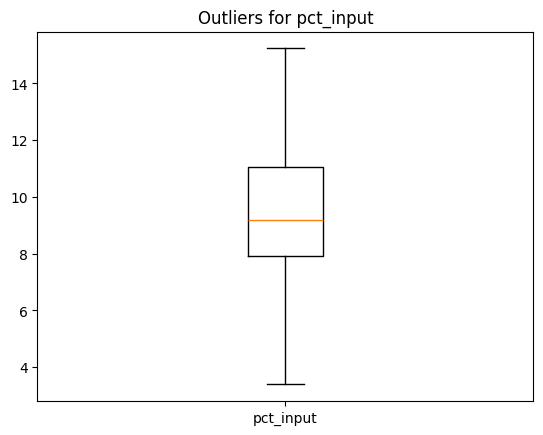

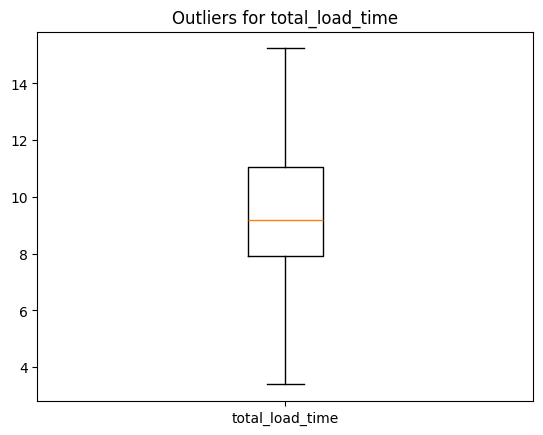

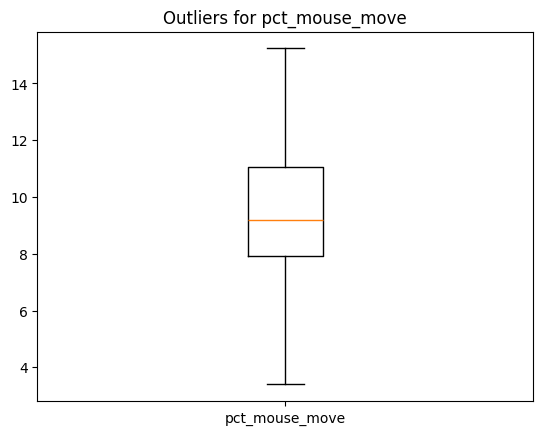

In [8]:
for o in top_outliers:
    plt_outliers(sess_df[o['col']], o['col'])

- Z grafov vidno, že outlier-y boli z testovacích datasetov úspešne odstránené. 

## Realizácia predspracovania dát
- Najskôr sme si naše datasety rozdelili na trénovacie a testovacie, a to tak, že testovaciemu sme pridelili __8 percent__ a zvyšok ostal na trénovanie.

In [9]:
def split_data(df, split = 20):
    num_rows_first_subset = int(len(df) * (split / 100.0))

    first_subset = df.head(num_rows_first_subset)
    second_subset = df.tail(len(df) - num_rows_first_subset)

    return first_subset, second_subset

prod_test_df, prod_train_df = split_data(prod_df, 8)
sess_test_df, sess_train_df = split_data(sess_df, 8)
user_test_df, user_train_df = split_data(user_df, 8)

### Kódovanie kategorických hodnôt
- Najskôr je nutné atribúty, ktoré sú logicky kategóriami, ale pandas knižnica ich rozoznáva ako objekty, manuálne označiť ako kategórie. Kategóriami sme neoznačovali atribúty s veľkým množstvom hodnôt, napr. __mená užívateľov__.
- Následne možno zakódovať označené kategórie na číselné hodnoty za pomoci __LabelEncoder__ objektu.

In [10]:
def make_category(df, name):
    df.loc[:, (name)] = df.loc[:, (name)].astype('category')

make_category(prod_train_df, 'location')
make_category(prod_train_df, 'store_name')
make_category(prod_train_df, 'code')

make_category(sess_train_df, 'browser_name')

make_category(user_train_df, 'race')
make_category(user_train_df, 'sex')

def encode_categories(df):
    enc = LabelEncoder()
    
    for col in df:
        if df[col].dtype.name == 'category': #isinstance(df[col].dtype, pd.CategoricalDtype): #pd.api.types.is_categorical_dtype(df[col]):
            print(f"Col {col} is categorical. Encoding...")
            df.loc[:, (col)] = enc.fit_transform(df.loc[:, (col)])
        else:
            print(f"Col {col} is not categorical. Skipping...")
            
encode_categories(prod_train_df)
encode_categories(sess_train_df)
encode_categories(user_train_df)

Col location is not categorical. Skipping...
Col product_ean is not categorical. Skipping...
Col store_name is not categorical. Skipping...
Col code is not categorical. Skipping...
Col browser_name is not categorical. Skipping...
Col pct_input is not categorical. Skipping...
Col wild_mouse_duration is not categorical. Skipping...
Col pct_scroll_move_duration is not categorical. Skipping...
Col pct_wild_mouse is not categorical. Skipping...
Col session_start is not categorical. Skipping...
Col pct_doubleclick is not categorical. Skipping...
Col pct_rage_click is not categorical. Skipping...
Col pct_click is not categorical. Skipping...
Col page_activity_duration is not categorical. Skipping...
Col product_ean is not categorical. Skipping...
Col pct_scrandom is not categorical. Skipping...
Col mouse_move_total_rel_distance is not categorical. Skipping...
Col pct_click_product_info is not categorical. Skipping...
Col scroll_move_total_rel_distance is not categorical. Skipping...
Col sessi

### Štandardizácia atribútov
- Teraz normalizujeme niektoré atribúty, ktoré majú vysoko rozdielne hodnoty. Pre tieto atribúty sme sa rozhodli najmä preto, lebo majú vysoko rozdielne hodnoty, čo môže byť pre niektoré algoritmy neprijateľné. Použijeme nato __MinMax škálovanie__.

#### Škálovanie atribútov 'pct_mouse_click' a 'pct_scroll_move'

In [14]:
# Create MinMaxScaler
min_max_scaler = MinMaxScaler()

# Specify columns to scale
columns_to_scale = ['pct_mouse_click', 'pct_scroll_move']

# Apply Min-Max scaling to the selected columns using .loc
sess_train_df.loc[:, columns_to_scale] = min_max_scaler.fit_transform(sess_train_df[columns_to_scale])

# Now you can safely access the 'pct_scroll_move' column
result_column = sess_train_df['pct_scroll_move']

#### Škálovanie atribútov 'pct_input' a 'pct_click_product_info'

In [16]:
min_max_scaler = MinMaxScaler()
columns_to_scale = ['pct_input', 'pct_click_product_info']

sess_train_df.loc[:, columns_to_scale] = min_max_scaler.fit_transform(sess_train_df[columns_to_scale])
sess_train_df['pct_input']

885      0.002655
886      0.000239
887      0.009290
888      0.440234
889      1.000000
           ...   
11094    0.046492
11095    0.000000
11096    0.014678
11097    0.015777
11098    0.052595
Name: pct_input, Length: 9708, dtype: float64

### Normalizácia atribútov
- V tejto časti normalizujeme vysoko rozdielne atribúty, pričom v tomto prípade nemáme limit na rozsah daných hodnôt. Využívame v tomto prípade __štandardnú normalizáciu__.

#### Škálovanie atribútov 'session_duration' a  'total_load_time'

In [20]:
std_scaler = StandardScaler()
columns_to_scale = ['session_duration', 'total_load_time']

sess_train_df.loc[:, columns_to_scale] = std_scaler.fit_transform(sess_train_df[columns_to_scale])
#sess_df['total_load_time']

In [22]:
std_scaler = StandardScaler()
columns_to_trans = ['pct_doubleclick', 'pct_wild_mouse']
sess_train_df.loc[:, columns_to_trans] = std_scaler.fit_transform(sess_train_df[columns_to_trans])

### Transformácia dát na normálne distribúcie
- Pre veľa algoritmov strojového učenia je lepšie, keď sú ich datasety viac Gauss-ovsky rozdelené. Preto je vhodné rôznorodé dáta transformovať  napríklad pomocou techniky __PowerTransformer__. Nižšie využijeme __Yeo-Johnson-ovu metódu__.


#### Transformácia atribútov 'pct_rage_click' a 'pct_scroll_move' pomocou Yeo-Johnson-ovej metódy
- Nižšie možno vidieť aj histogram transformovaných rozdelení, na ktorom sú zobrazené vcelku hodnoverné Gaussovské rozdelenia.

(array([[ 13.,  28.,  43.,  84., 126., 208., 321., 427., 575., 710., 828.,
         874., 945., 892., 849., 715., 586., 502., 364., 252., 172.,  97.,
          51.,  25.,  21.],
        [ 18.,  32.,  44.,  71., 156., 194., 312., 401., 573., 716., 764.,
         940., 952., 919., 872., 705., 606., 463., 323., 268., 178.,  82.,
          64.,  38.,  17.]]),
 array([-3.08771764, -2.84405005, -2.60038246, -2.35671487, -2.11304728,
        -1.86937969, -1.6257121 , -1.38204452, -1.13837693, -0.89470934,
        -0.65104175, -0.40737416, -0.16370657,  0.07996102,  0.32362861,
         0.5672962 ,  0.81096379,  1.05463137,  1.29829896,  1.54196655,
         1.78563414,  2.02930173,  2.27296932,  2.51663691,  2.7603045 ,
         3.00397209]),
 <a list of 2 BarContainer objects>)

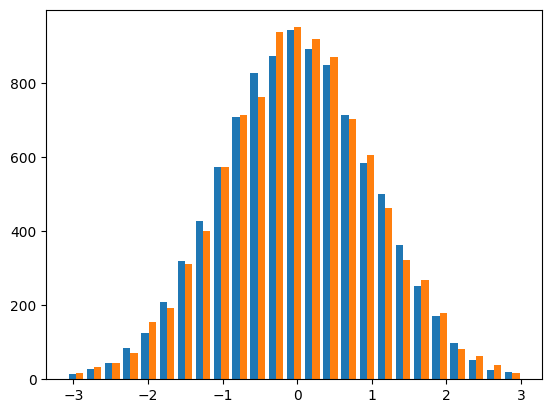

In [24]:
columns_to_scale = ['pct_rage_click', 'pct_scroll_move']

power = PowerTransformer(
method='yeo-johnson', 
standardize=True) 
sess_train_df.loc[:, columns_to_scale] = power.fit_transform(sess_train_df[columns_to_scale])

pyplot.hist(sess_train_df[columns_to_scale], bins=25)